## Growth Model Validation (v2)

Current model:
    
ODE: $ \frac{dy}{dt} = c_ry + \frac{c_d}{1 + e^{-c_s(t-c_0)}}y$

Where: 
 
- $y$ is the number of cells
- $t$ time in days
- $c_r$ is the growth rate
- $c_d$ is death rate
- $c_0$ is an offset in time after which the death rate starts to take effect
- $c_s$ is speed with which sigmoid activates death rate on or off (high values approximate discrete cutpoint)

Solution (Wolfram: https://www.wolframalpha.com/input/?i=y%27+%3D+a*y+%2B+b*(+1+%2F+(1+%2B+exp(-s*(x+-+c)))+)*y) ): 
$$y = P_0 e^{c_rt} (e^{c_s c_0} + e^{c_s t})^{\frac{c_d}{c_s}}$$ 

    

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotnine as pn
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf

In [33]:
# Generate a simple example for testing
y = np.array([1, 2, 4, 5, 7, 5, 6, 3, 4, 2, 1, 0, 0, 0, 0])
# y = np.repeat(1, 15)
t = np.arange(len(y)) 
np.vstack((t, y))

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [ 1,  2,  4,  5,  7,  5,  6,  3,  4,  2,  1,  0,  0,  0,  0]])

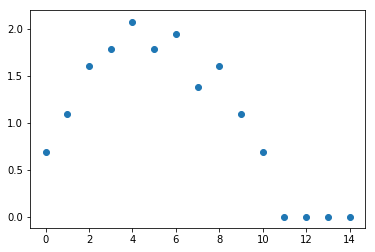

In [34]:
plt.scatter(t, np.log(y + 1))

In [40]:
import tensorflow as tf
    
    
    
class Model(object):

    def __init__(self, init_params={}):
        self.init_params = init_params
        
    def _get_model(self, init_count, speed):
        t = tf.placeholder(tf.float32, shape=(None,))
        y = tf.placeholder(tf.float32, shape=(None,))
        gR = tf.nn.softplus(tf.Variable(self.init_params.get('growth_rate', 0.)))
        dR = -tf.nn.softplus(tf.Variable(self.init_params.get('death_rate', 0.)))
        dO = tf.nn.softplus(tf.Variable(self.init_params.get('death_onset', 0.)))

        if speed is None:
            dS = tf.nn.softplus(tf.Variable(self.init_params.get('switch_speed', 1.)))
        else:
            dS = tf.cast(speed, dtype=tf.float32)
        if init_count is None:
            p0 = tf.Variable(self.init_params.get('initial_count', 1.))
        else:
            p0 = tf.cast(init_count, dtype=tf.float32)
        
        exps = tf.stack([dO*dS*tf.ones_like(t), t*dS])
        yp = tf.exp(tf.log(p0) + gR * t + (dR / dS) * tf.reduce_logsumexp(exps, axis=0))
        loss = tf.reduce_mean(tf.square(yp - y))
        
        return [gR, dR, dO, dS, p0], [t, y], yp, loss
        
    def fit(self, X, y, init_count=None, speed=None):
        
        self.losses_ = []
        
        self.graph_ = tf.Graph()
        self.sess_ = tf.Session(graph=self.graph_)
        with self.graph_.as_default():
            [gR, dR, dO, dS, p0], [tp, yp], target, loss = self._get_model(init_count, speed)
            self.prediction_target_ = target
            self.input_holder_ = tp
            
            train_op = tf.train.RMSPropOptimizer(.01).minimize(loss)
            init_op = tf.global_variables_initializer()
            
            self.sess_.run(init_op)
            losses = []
            for i in range(2500):
                _, l = self.sess_.run([train_op, loss], feed_dict={tp: X, yp: y})
                self.losses_.append(l)
            self.coefs_ = self.sess_.run([gR, dR, dO, dS, p0])
        return self
    
    def predict(self, X):
        y = self.sess_.run(self.prediction_target_, {self.input_holder_: X})
        return y
    
    def close(self):
        self.sess_.close()
        return self

In [41]:
m = Model().fit(t, y, init_count=None, speed=5)

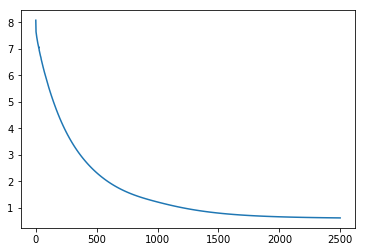

In [42]:
plt.plot(m.losses_)

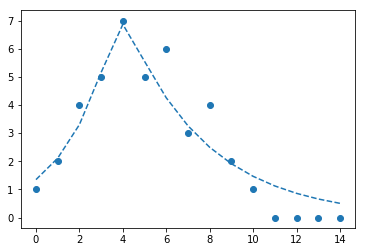

In [43]:
plt.scatter(t, y)
plt.plot(t, m.predict(t), '--')

In [39]:
m.coefs_

[0.6967223, -0.7486187, 1.586842, 5.0, 3.4955335]

In [12]:
m.close()

## More Realistic Examples

In [13]:
examples = '{"0:K562:Imatinib:150nM:Orange:1:16:10":{"0":1.0,"18":2.0,"41":4.0,"72":8.0,"92":14.0,"119":17.0,"139":20.0},"0:K562:Imatinib:150nM:Orange:1:37:11":{"0":1.0,"18":2.0,"41":6.0,"72":11.0,"92":23.0,"119":44.0,"139":63.0},"0:K562:Imatinib:150nM:Orange:1:26:12":{"0":1.0,"18":3.0,"41":4.0,"72":11.5,"92":19.0,"119":29.0,"139":31.0},"0:K562:Imatinib:150nM:Orange:1:17:04":{"0":1.0,"18":2.0,"41":5.0,"72":10.0,"92":17.0,"119":21.0,"139":30.0},"0:K562:Imatinib:150nM:Orange:1:02:25":{"0":1.0,"18":2.0,"41":3.5,"72":5.0,"92":7.0,"119":13.0,"139":16.0},"0:K562:Imatinib:150nM:Orange:1:28:02":{"0":1.0,"18":1.0,"41":4.0,"72":6.0,"92":17.0,"119":21.0,"139":28.0},"0:K562:Imatinib:150nM:Orange:1:45:25":{"0":1.0,"18":2.0,"41":4.0,"72":9.0,"92":10.0,"119":12.0,"139":19.0},"0:K562:Imatinib:150nM:Orange:1:36:03":{"0":1.0,"18":5.0,"41":9.0,"72":25.0,"92":39.0,"119":55.0,"139":13.0},"0:K562:Imatinib:150nM:Orange:1:25:00":{"0":1.0,"18":3.0,"41":8.0,"72":16.0,"92":23.0,"119":31.0,"139":34.0},"0:K562:Imatinib:150nM:Orange:1:30:24":{"0":1.0,"18":2.0,"41":4.0,"72":14.0,"92":24.0,"119":48.0,"139":58.0},"1:K562:Imatinib:150nM:Orange:1:31:03":{"0":1.0,"18":2.0,"41":2.0,"72":5.0,"92":1.0,"119":2.0,"139":2.0},"1:K562:Imatinib:150nM:Orange:1:04:25":{"0":1.0,"18":3.0,"41":6.0,"72":9.0,"92":9.0,"119":11.0,"139":10.0},"1:K562:Imatinib:150nM:Orange:1:31:07":{"0":1.0,"18":3.0,"41":4.0,"72":4.0,"92":5.0,"119":2.0,"139":2.0},"1:K562:Imatinib:150nM:Orange:1:40:30":{"0":1.0,"18":2.0,"41":2.0,"72":4.0,"92":2.0,"119":0.0,"139":0.0},"1:K562:Imatinib:150nM:Orange:1:36:29":{"0":1.0,"18":4.0,"41":7.0,"72":12.0,"92":13.0,"119":10.0,"139":11.0},"1:K562:Imatinib:150nM:Orange:1:30:20":{"0":1.0,"18":3.0,"41":2.0,"72":6.0,"92":6.0,"119":4.0,"139":5.0},"1:K562:Imatinib:150nM:Orange:1:25:30":{"0":1.0,"18":2.0,"41":2.0,"72":2.0,"92":3.0,"119":6.0,"139":10.0},"1:K562:Imatinib:150nM:Orange:1:03:14":{"0":1.0,"18":2.0,"41":4.0,"72":4.0,"92":3.0,"119":4.0,"139":4.0},"1:K562:Imatinib:150nM:Orange:1:22:20":{"0":1.0,"18":2.0,"41":3.0,"72":2.0,"92":4.0,"119":5.0,"139":7.0},"1:K562:Imatinib:150nM:Orange:1:31:20":{"0":1.0,"18":2.0,"41":3.0,"72":3.0,"92":4.0,"119":2.0,"139":3.0},"2:K562:Imatinib:150nM:Orange:1:02:26":{"0":1.0,"18":2.0,"41":2.0,"72":1.0,"92":1.0,"119":4.0,"139":2.0},"2:K562:Imatinib:150nM:Orange:1:06:19":{"0":1.0,"18":0.0,"41":0.0,"72":0.0,"92":2.0,"119":1.0,"139":1.0},"2:K562:Imatinib:150nM:Orange:1:21:10":{"0":1.0,"18":1.0,"41":1.0,"72":1.0,"92":2.0,"119":2.0,"139":4.0},"2:K562:Imatinib:150nM:Orange:1:43:18":{"0":1.0,"18":2.0,"41":2.0,"72":3.0,"92":3.0,"119":1.0,"139":2.0},"2:K562:Imatinib:150nM:Orange:1:32:18":{"0":1.0,"18":2.0,"41":3.0,"72":1.0,"92":1.0,"119":0.0,"139":1.0},"2:K562:Imatinib:150nM:Orange:1:34:18":{"0":1.0,"18":1.0,"41":1.0,"72":1.0,"92":1.0,"119":1.0,"139":1.0},"2:K562:Imatinib:150nM:Orange:1:11:02":{"0":1.0,"18":2.0,"41":1.0,"72":1.0,"92":1.0,"119":1.0,"139":0.0},"2:K562:Imatinib:150nM:Orange:1:15:23":{"0":1.0,"18":1.0,"41":0.0,"72":0.0,"92":0.0,"119":2.0,"139":4.0},"2:K562:Imatinib:150nM:Orange:1:17:29":{"0":1.0,"18":1.0,"41":1.0,"72":1.0,"92":1.0,"119":1.0,"139":0.0},"2:K562:Imatinib:150nM:Orange:1:26:07":{"0":1.0,"18":2.0,"41":1.0,"72":1.0,"92":1.0,"119":1.0,"139":2.0},"3:K562:Imatinib:150nM:Orange:1:30:25":{"0":1.0,"18":0.0,"41":0.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0},"3:K562:Imatinib:150nM:Orange:1:03:18":{"0":1.0,"18":1.0,"41":1.0,"72":1.0,"92":0.0,"119":0.0,"139":1.0},"3:K562:Imatinib:150nM:Orange:1:20:22":{"0":1.0,"18":2.0,"41":3.0,"72":1.0,"92":0.0,"119":0.0,"139":0.0},"3:K562:Imatinib:150nM:Orange:1:18:27":{"0":1.0,"18":2.0,"41":2.0,"72":1.0,"92":0.0,"119":0.0,"139":0.0},"3:K562:Imatinib:150nM:Orange:1:18:26":{"0":1.0,"18":2.0,"41":2.0,"72":1.0,"92":0.0,"119":0.0,"139":0.0},"3:K562:Imatinib:150nM:Orange:1:25:03":{"0":1.0,"18":2.0,"41":2.0,"72":1.0,"92":1.0,"119":0.0,"139":0.0},"3:K562:Imatinib:150nM:Orange:1:21:25":{"0":1.0,"18":2.0,"41":2.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0},"3:K562:Imatinib:150nM:Orange:1:30:04":{"0":1.0,"18":0.0,"41":0.0,"72":0.0,"92":0.0,"119":1.0,"139":1.0},"3:K562:Imatinib:150nM:Orange:1:41:00":{"0":1.0,"18":1.0,"41":0.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0},"3:K562:Imatinib:150nM:Orange:1:40:28":{"0":1.0,"18":0.0,"41":2.0,"72":2.0,"92":1.0,"119":0.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:30:23":{"0":1.0,"18":2.0,"41":0.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:03:08":{"0":1.0,"18":2.0,"41":1.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:45:30":{"0":1.0,"18":2.0,"41":1.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:31:02":{"0":1.0,"18":3.0,"41":0.0,"72":0.0,"92":1.0,"119":0.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:30:30":{"0":1.0,"18":3.0,"41":1.0,"72":1.0,"92":0.0,"119":0.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:42:20":{"0":1.0,"18":2.0,"41":0.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:34:29":{"0":1.0,"18":2.0,"41":1.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:37:00":{"0":1.0,"18":4.0,"41":1.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:42:09":{"0":1.0,"18":2.0,"41":0.0,"72":0.0,"92":0.0,"119":1.0,"139":0.0},"4:K562:Imatinib:150nM:Orange:1:19:28":{"0":1.0,"18":2.0,"41":0.0,"72":0.0,"92":0.0,"119":0.0,"139":0.0}}'
df = pd.read_json(examples, orient='index')
df.columns = [np.round(v, 2) for v in df.columns / 24]
df.columns.name = 'time'
df = df[sorted(df.columns)]
df.index.name = 'address'
df.head()

time,0.0,0.75,1.71,3.0,3.83,4.96,5.79
address,,,,,,,
0:K562:Imatinib:150nM:Orange:1:02:25,1,2,3.5,5.0,7,13,16
0:K562:Imatinib:150nM:Orange:1:16:10,1,2,4.0,8.0,14,17,20
0:K562:Imatinib:150nM:Orange:1:17:04,1,2,5.0,10.0,17,21,30
0:K562:Imatinib:150nM:Orange:1:25:00,1,3,8.0,16.0,23,31,34
0:K562:Imatinib:150nM:Orange:1:26:12,1,3,4.0,11.5,19,29,31


In [17]:
import tqdm
def get_predictions():
    dfp = []
    coefs = {}
    for i, r in tqdm.tqdm(list(df.iterrows())):
        m = Model()
        X = r.index.values
        y = r.values
        m.fit(X, y, init_count=None, speed=5)
        yp = m.predict(X)
        m.close()
        coefs[i] = m.coefs_
        dfp.append(pd.Series(yp, index=r.index, name=i))
    return pd.DataFrame(dfp), coefs
dfp, coefs = get_predictions()

100%|██████████| 50/50 [05:11<00:00,  6.21s/it]


In [18]:
def flatten(df):
    df.index.name = 'address'
    df = df.stack().rename('count')
    return df.reset_index()

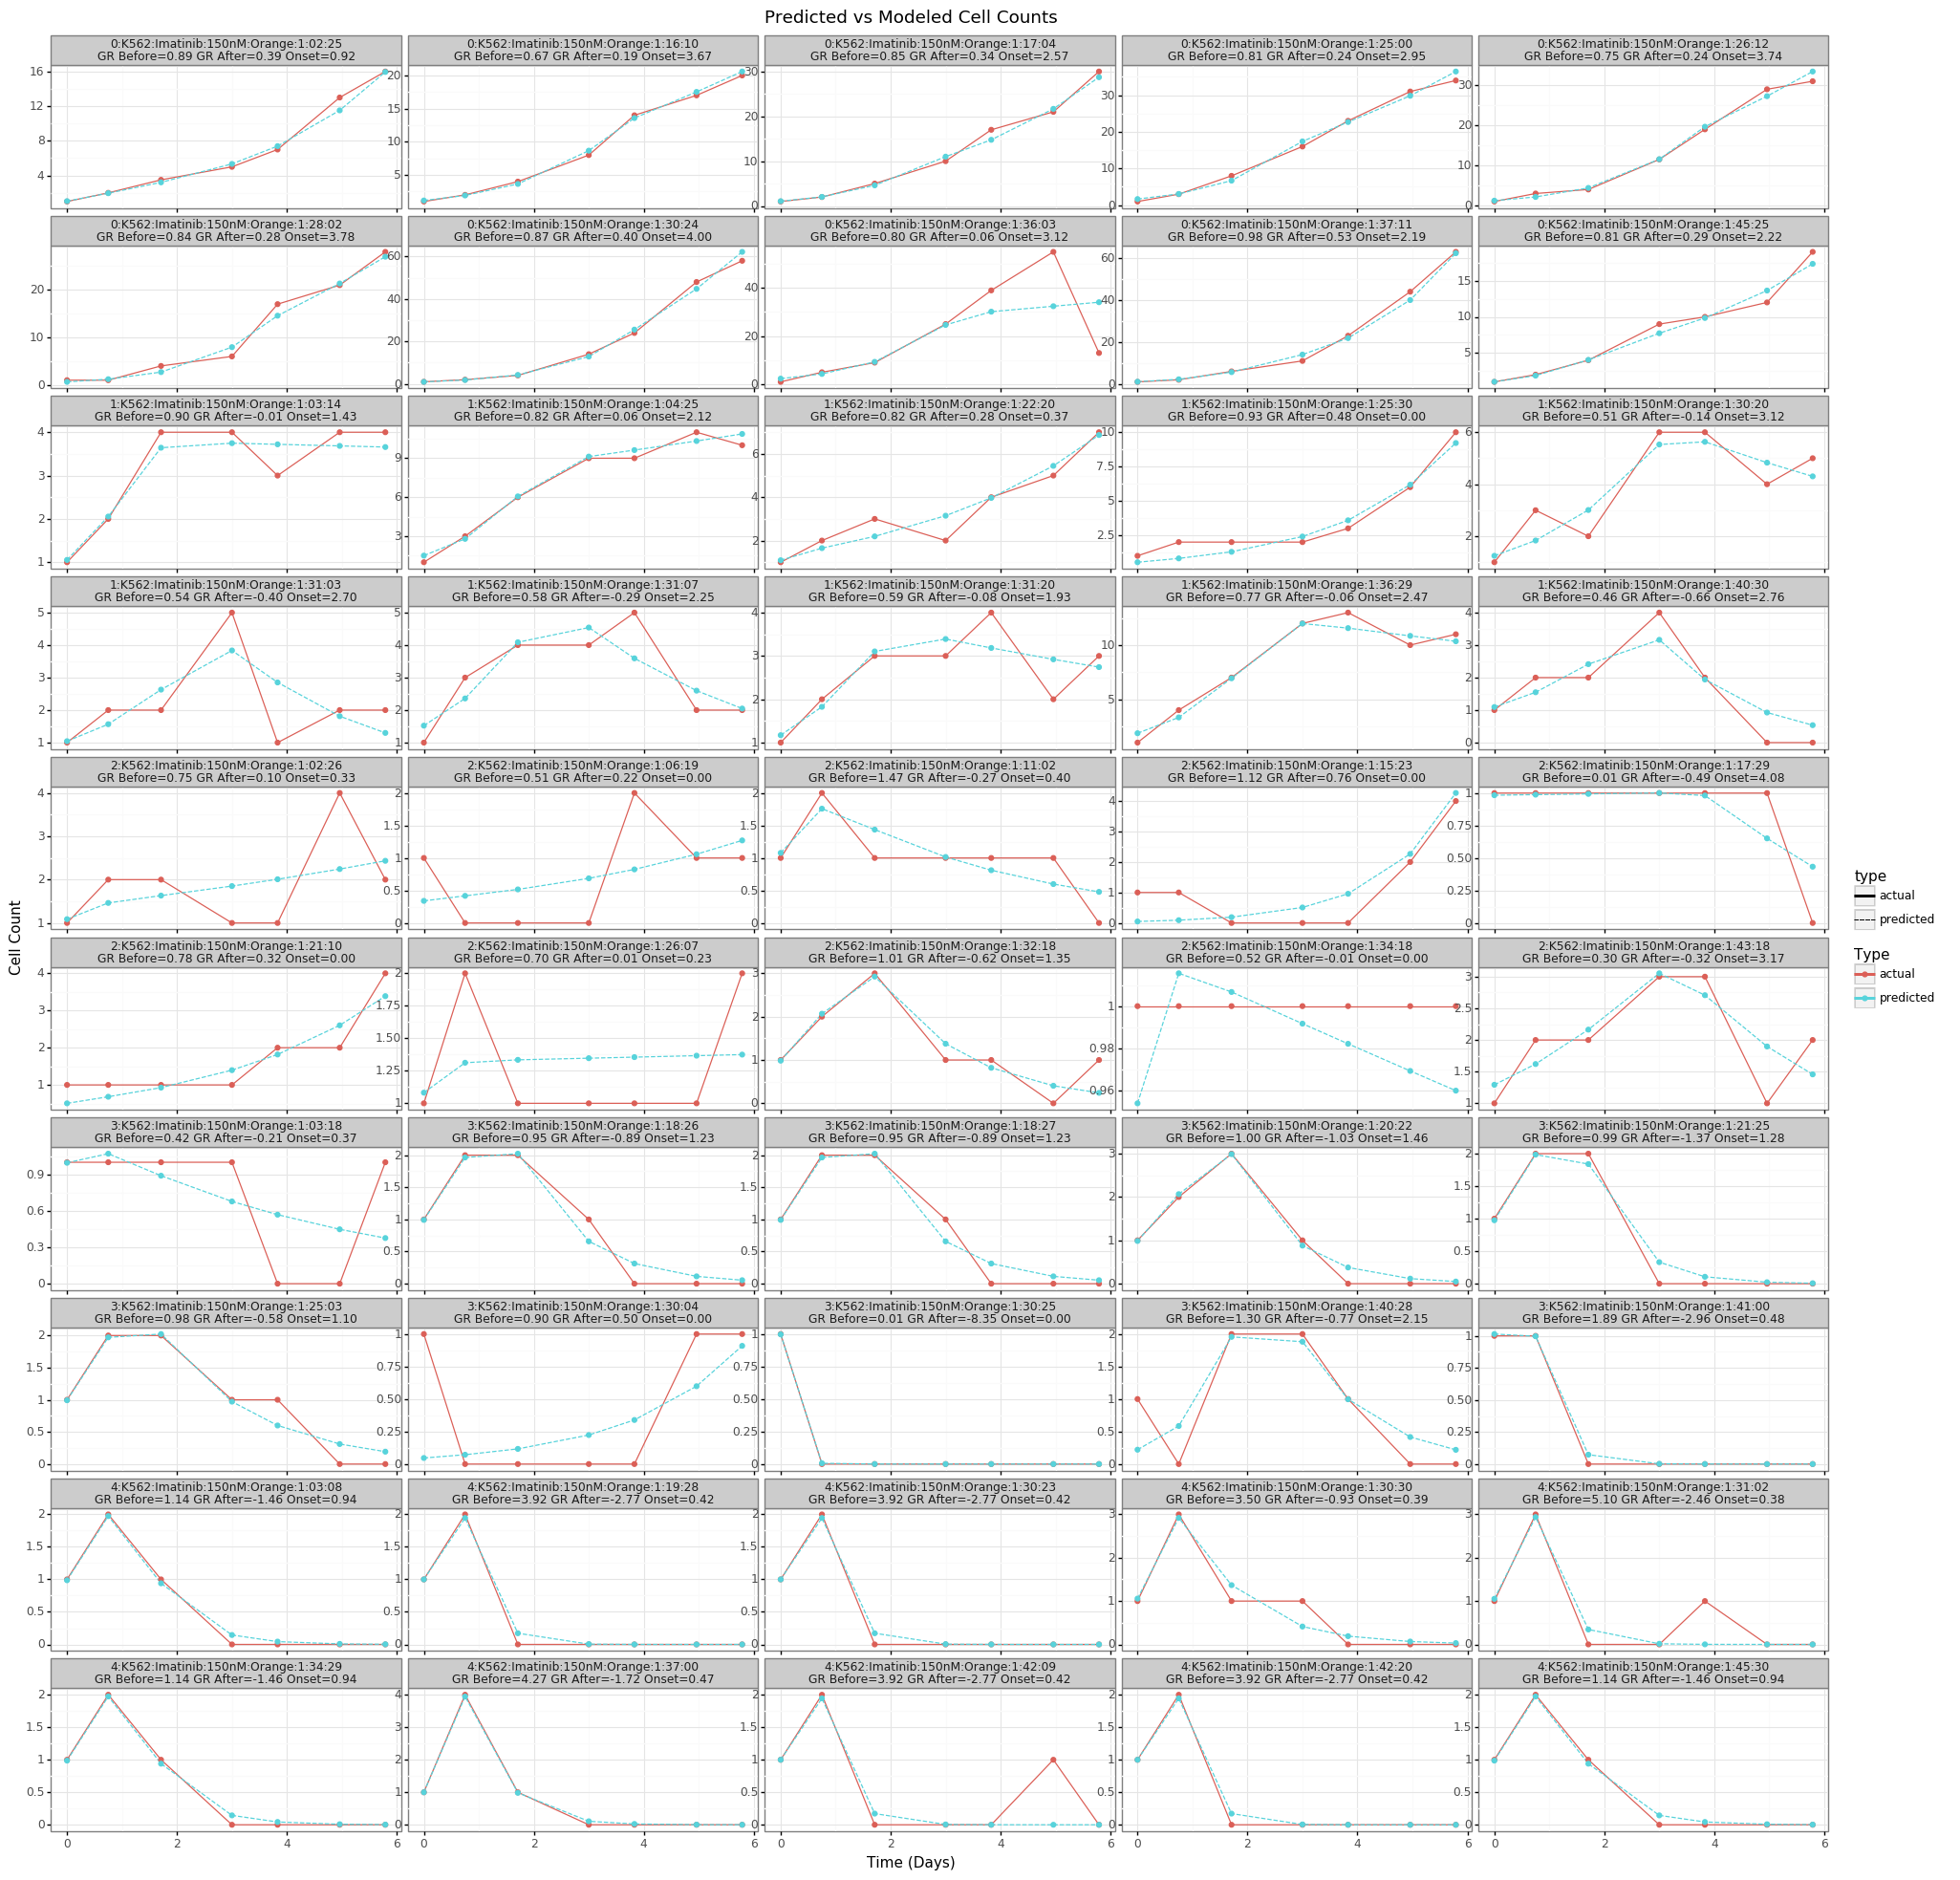

<ggplot: (8792851982635)>

In [21]:
coef_summary = {
    k: 'GR Before={:.2f} GR After={:.2f} Onset={:.2f}'.format(v[0], v[0]+v[1], v[2])
    for k, v in coefs.items()
}
(
    pn.ggplot(
        pd.concat([
            flatten(df).assign(type='actual'),
            flatten(dfp).assign(type='predicted')
        ])
        .assign(coefs=lambda d: d['address'].map(coef_summary)),
        pn.aes(x='time', y='count', color='type', linetype='type') 
    ) +
    pn.geom_line() +
    pn.geom_point() +
    pn.labs(x='Time (Days)', y='Cell Count', color='Type', title='Predicted vs Modeled Cell Counts') +
    pn.facet_wrap('~ address + coefs', scales='free', ncol=5) +
    pn.theme_bw() +
    pn.theme(figure_size=(24, 24))
)